## Реализация случайного леса

Для лучшего понимания алгоритма построения случайного леса реализуем его на Python.

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [2]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=42)

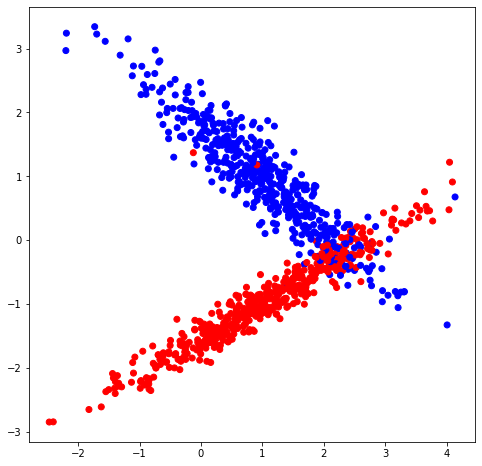

In [3]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

Реализуем генерацию $N$ бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

In [4]:
random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

Далее повторим реализацию построения дерева решений из предыдущего урока с некоторыми изменениями

In [6]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [7]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [9]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [10]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [11]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 1

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # выбор индекса из подвыборки длиной sqrt(n_features)
    subsample = get_subsample(n_features)
    
    for index in subsample:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [12]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Теперь добавим функцию формирования случайного леса.

In [13]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [14]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [15]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [16]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

Далее мы сделаем обычное разбиение выборки на обучающую и тестовую, как это делалось ранее. Оценить ошибку этого же алгоритма по методу Out-of-Bag будет вашим домашним заданием к этому уроку.

In [17]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [18]:
# Введем функцию подсчета точности как доли правильных ответов

def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь построим несколько случайных лесов с разным количеством деревьев в них.

Построим лес из одного дерева

In [19]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

In [20]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_1, train_data)

In [21]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_1, test_data)

In [22]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 1 деревьев на обучающей выборке: 95.571


In [23]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 1 деревьев на тестовой выборке: 86.333


Построим лес из трех деревьев

In [24]:
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

In [25]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_3, train_data)

In [26]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_3, test_data)

In [27]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 3 деревьев на обучающей выборке: 97.857


In [28]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 3 деревьев на тестовой выборке: 92.000


Построим лес из десяти деревьев

In [29]:
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

In [30]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_10, train_data)

In [31]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_10, test_data)

In [32]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 10 деревьев на обучающей выборке: 98.857


In [33]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 10 деревьев на тестовой выборке: 95.667


Построим лес из пятидесяти деревьев

In [34]:
n_trees = 50
my_forest_50 = random_forest(train_data, train_labels, n_trees)

In [35]:
# Получим ответы для обучающей выборки 
train_answers = tree_vote(my_forest_50, train_data)

In [36]:
# И получим ответы для тестовой выборки
test_answers = tree_vote(my_forest_50, test_data)

In [37]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

Точность случайного леса из 50 деревьев на обучающей выборке: 100.000


In [38]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, test_answers)
print(f'Точность случайного леса из {n_trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

Точность случайного леса из 50 деревьев на тестовой выборке: 93.333


Как можно увидеть из показателей качества предсказаний, точность случайного леса возрастает при увеличении числа деревьев в нем. При этом по точности на тестовой выборке можно сказать, что при увеличении количества деревьев до 50 наш лес не переобучается. Это одна из основных особенностей случайного леса - он не переобучается при увеличении числа базовых алгоритмов, а ошибка выходит на асимптоту.

**Разделяющие гиперплоскости**

In [41]:
def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

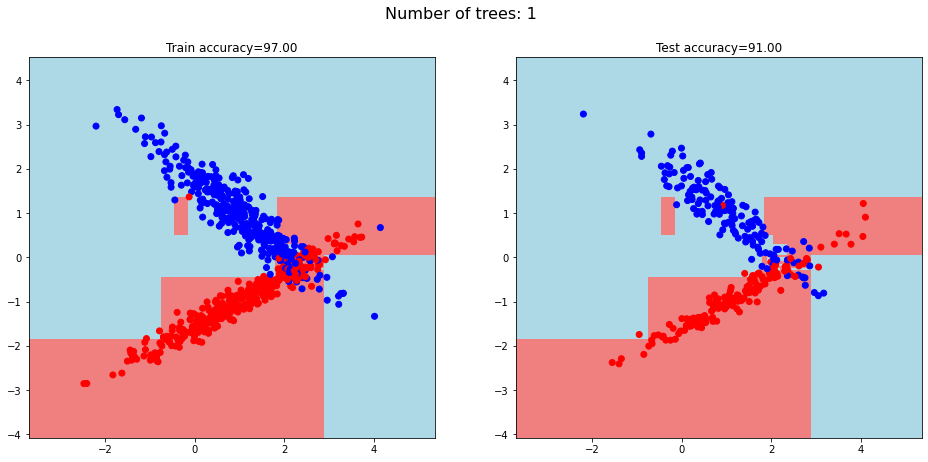

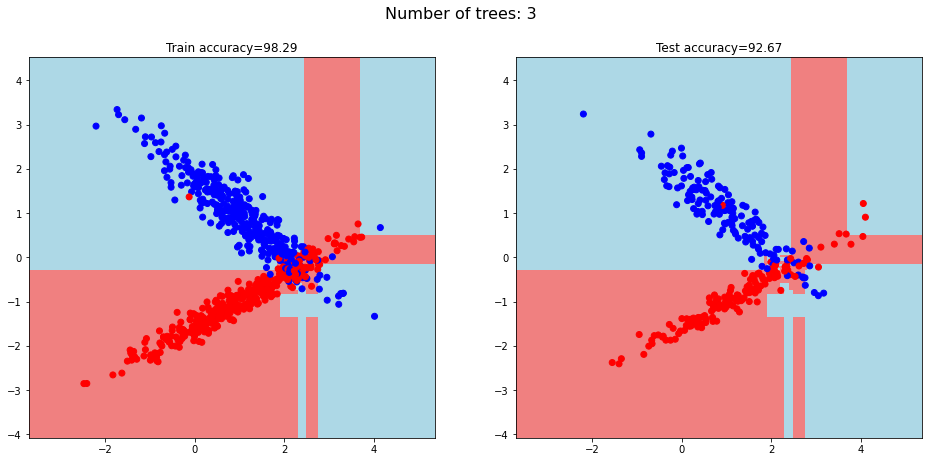

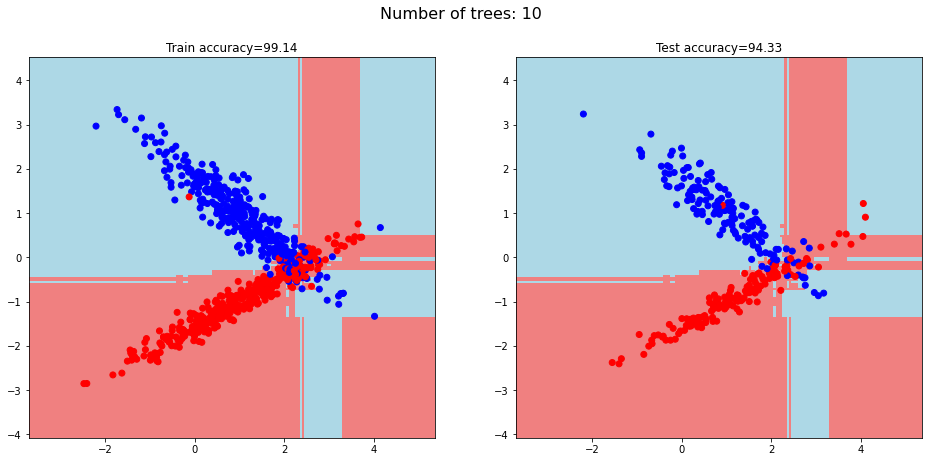

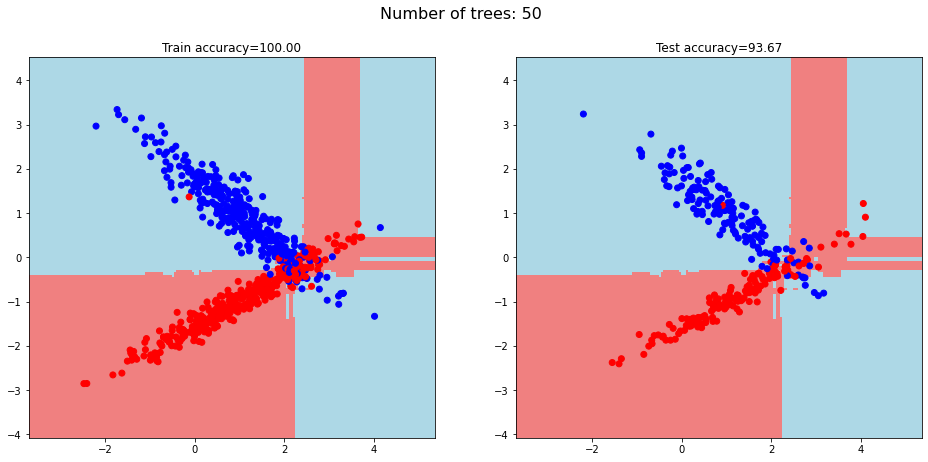

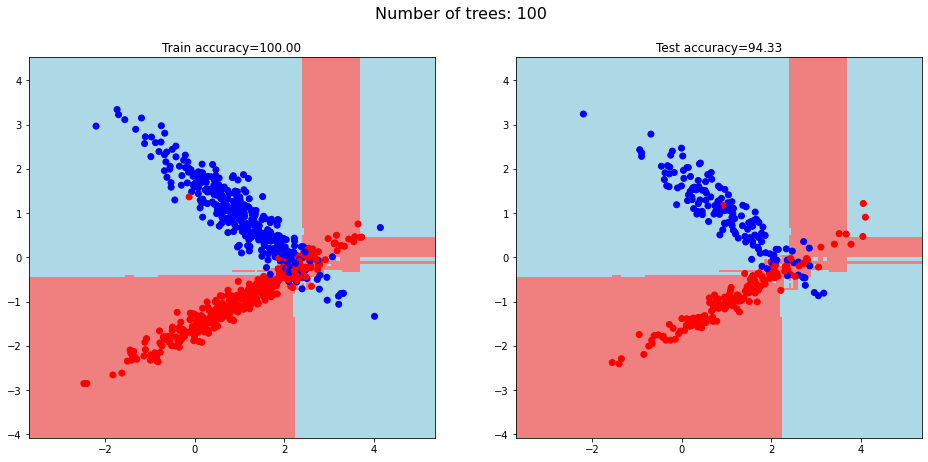

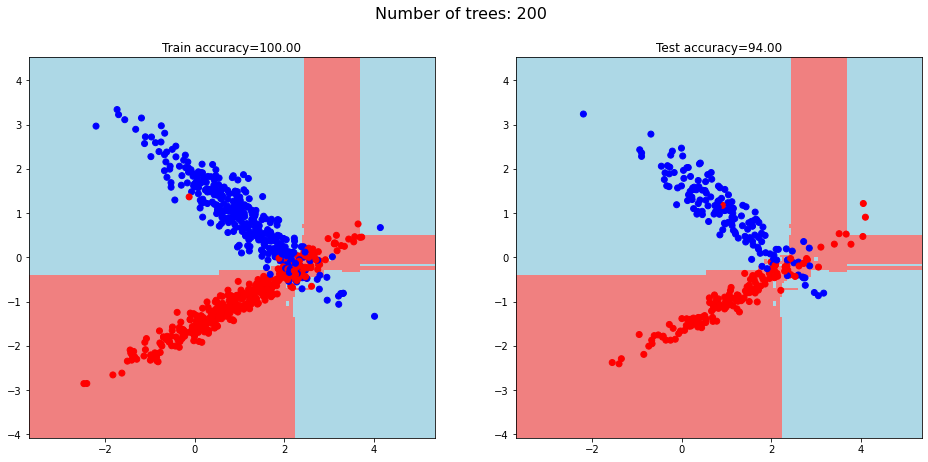

In [42]:
trees_list = [1, 3, 10, 50, 100, 200]
for trees in trees_list:
    my_forest = random_forest(train_data, train_labels, trees)
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    test_accuracy = accuracy_metric(test_labels, test_answers)

    fig = plt.figure(figsize = (16, 7))
    fig.suptitle(f'Number of trees: {trees}', fontsize=16)
    ax1 = fig.add_subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax1.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    ax1.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    ax1.set(title = f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    ax2 = fig.add_subplot(1,2,2)
    ax2.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors, shading='auto')
    ax2.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    ax2.set(title = f'Test accuracy={test_accuracy:.2f}')
plt.show()

**Out-of-Bag**

Если я правильно понял то нам нужно изменить функцию get_bootstrap, чтобы получить данные не вошедшие в бутстрап выборки и потом использовать их как тестовые данные

In [53]:
random.seed(42)

def get_bootstrap_oob(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
# добавляем список в котором будут храниться данные не попавшие в бутстрап выборку
    oob = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        # сюда будем записывать индексы бутстрап выборки, в oob данные попадут все записи с индексами не входящими в этот список
        bootstrap_indeсes = []
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            bootstrap_indeсes.append(sample_index)
        bootstrap.append((b_data, b_labels))
        #генерируем список для oob данных
        oob_data = [j for i,j in enumerate(classification_data) if i not in bootstrap_indeсes]
        oob_labels = [j for i,j in enumerate(classification_labels) if i not in bootstrap_indeсes]
        oob.append((np.array(oob_data), np.array(oob_labels)))
      
    return bootstrap, oob

In [56]:
def random_forest_oob(data, labels, n_trees):
    forest = []
    bootstrap, oob = get_bootstrap_oob(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest, bootstrap, oob

Теперь нам не нужно разбивать данные на train и test.Обучим деревья на отложенной выборке  и на Out-of-Bag и сравним результат.

In [65]:
num_of_trees = [1, 3, 10, 50, 100]

for trees in num_of_trees:
    
    my_forest = random_forest(train_data, train_labels, trees)
    my_forest_oob, bootstrap, oob = random_forest_oob(classification_data, classification_labels, trees)

    # Получим ответы для обучающей выборки 
    train_answers = tree_vote(my_forest, train_data)

    bootstrap_data = bootstrap[0][0]
    bootstrap_labels = bootstrap[0][1]
    oob_data = oob[0][0]
    oob_labels = oob[0][1]

    # Получим ответы для bootstrap выборки 
    bootstrap_answers = tree_vote(my_forest_oob, bootstrap_data)


    # Получим ответы для тестовой выборки
    test_answers = tree_vote(my_forest, test_data)

    # Получим ответы для OOB выборки
    oob_answers = tree_vote(my_forest, oob_data)

    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Точность случайного леса из {trees} деревьев на обучающей выборке: {train_accuracy:.3f}')

    # Точность на bootstrap выборке
    bootstrap_accuracy = accuracy_metric(bootstrap_labels, bootstrap_answers)
    print(f'Точность случайного леса из {trees} деревьев на bootstrap выборке: {train_accuracy:.3f}')


    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Точность случайного леса из {trees} деревьев на тестовой выборке: {test_accuracy:.3f}')

    # Точность на OOB выборке
    oob_accuracy = accuracy_metric(oob_labels, oob_answers)
    print(f'Точность случайного леса из {trees} деревьев на OOB выборке: {test_accuracy:.3f}')
    print('\n\n')

Точность случайного леса из 1 деревьев на обучающей выборке: 97.857
Точность случайного леса из 1 деревьев на bootstrap выборке: 97.857
Точность случайного леса из 1 деревьев на тестовой выборке: 89.333
Точность случайного леса из 1 деревьев на OOB выборке: 89.333



Точность случайного леса из 3 деревьев на обучающей выборке: 98.286
Точность случайного леса из 3 деревьев на bootstrap выборке: 98.286
Точность случайного леса из 3 деревьев на тестовой выборке: 93.000
Точность случайного леса из 3 деревьев на OOB выборке: 93.000



Точность случайного леса из 10 деревьев на обучающей выборке: 99.000
Точность случайного леса из 10 деревьев на bootstrap выборке: 99.000
Точность случайного леса из 10 деревьев на тестовой выборке: 95.667
Точность случайного леса из 10 деревьев на OOB выборке: 95.667



Точность случайного леса из 50 деревьев на обучающей выборке: 100.000
Точность случайного леса из 50 деревьев на bootstrap выборке: 100.000
Точность случайного леса из 50 деревьев на тестовой 